# ASSESSING FLOOD RISK IN SAN SALVADOR

In [1]:
%%capture
# generate plots used in this script
import functions_ss
fig_ma, fig_point, fig_houses, fig_if = functions_ss.generate_plots_risk()

In [2]:
%matplotlib inline

## INTRODUCTION

San Salvador is the capital of El Salvador and by far the country’s largest city; the municipality itself has a population of slightly more than half a million, while the whole metropolitan area counts almost two and a half million inhabitants. The three major climate-related risks are floods, winds and landslides.

The region with greatest risk of flood of the metropolitan area is a section of the Acelhuate river of 17 km longitude and 10 km² surface (highlighted in blue in the following figure). In this region the population density is very high (65,000 inhabitants/10 km²) and vulnerable urban settlements (Asentamientos Urbanos Precarios, hereafter AUP) coexist near high-value buildings.

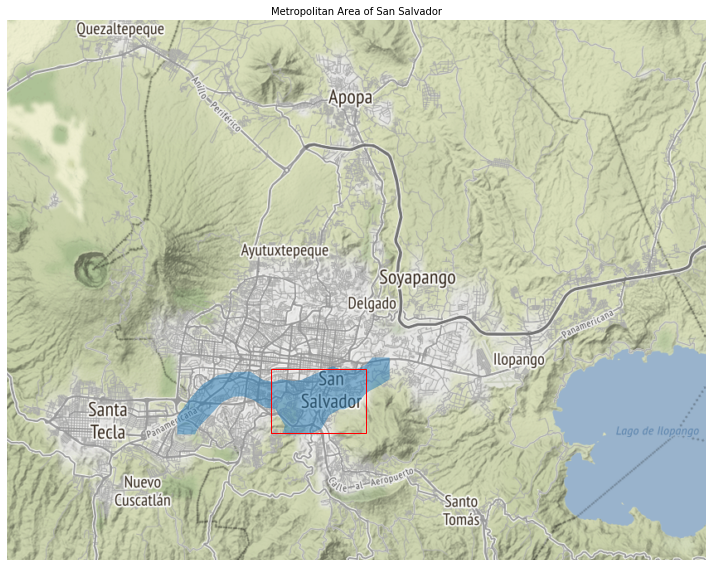

In [3]:
fig_ma

## FLOOD RISK AT ONE LOCATION

Let us compute the risk of flood in a vulnerable settlement located at 13.6856° N 89.193° W, inside the red rectangle of the previous image at the following black marker:

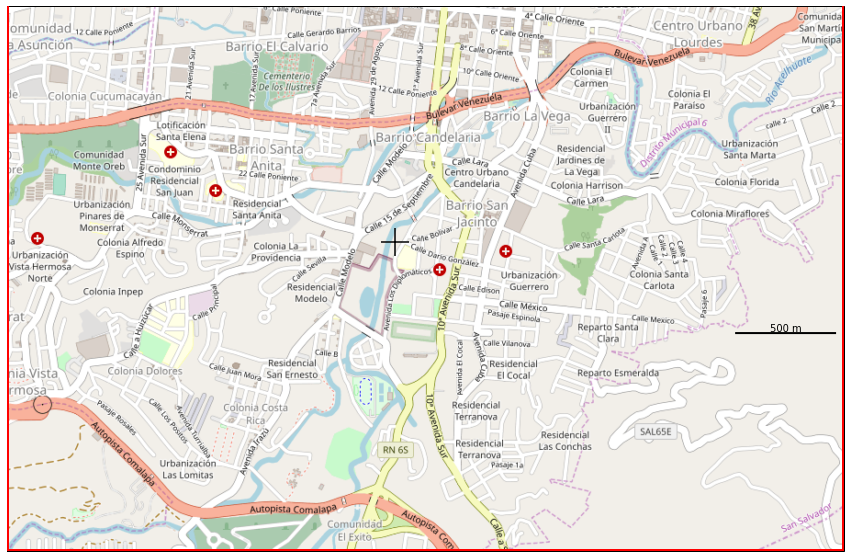

In [4]:
fig_point

Approximately once every 10 years floods exceeding 77 cm in height have occured at this location. Local hydrological models show that 2.8 m water (3.5 times more!) are exceeded every 25 years and 5.7 m every 100 years.

When the water level exceeds 2.0 m, 100% of the house gets typically damaged in vulnerable settlements. The function relating water height with percentage of damage can be approximated using the HAZUS model:


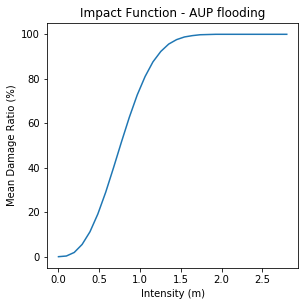

In [5]:
fig_if

Taking into account that the house is valued at 9,234.8 USD, one can put these numbers together to estimate the expected damage. For every event $i$ with return period $RP_i$ the impact is
$$impact_{i} = f_{imp}(intensity_{i})*value, i\in[1, 4]$$

where 
* $RP=\{10, 25, 50, 100\}$ is the event's return period in years.
* $f_{imp}$ is the impact function of this house type, relating the flood intensity (water height) with the Mean Damage Ratio.
* $intensity_{i}$ is the water height of event $i$ at the location.
* $value$ is 18300 USD, the house value.

Then, the Expected Annual Impact (EAI) is the sum of the frequencies by the impacts:
$$EAI = \sum_{i=1}^4 \frac{1}{RP_{i}} impact_{i} $$

These computations can be easily done in an Excel sheet as follows:

In [6]:
acc_df = functions_ss.load_accounting() # load accounting.xlsx
acc_df.head()

,Return Period (year),frequency (1/year),intensity (m),Mean Damage Ration (%),impact (USD),frequency * impact,Expected Annual Impact
1,10,0.10,0.774454,51.83603,4786.95371,478.695371,1125.131371
2,25,0.04,2.820973,100.00000,9234.80000,369.392000,NaN
3,50,0.02,4.828216,100.00000,9234.80000,184.696000,NaN
4,100,0.01,5.742804,100.00000,9234.80000,92.348000,NaN


At this location, the expected annual impact is 1,125 USD, one eighth of the house's value. This is the amount of money one should put aside each year to cover for all the future damages of this house.

To repeat these computations for a bigger set of assets might become cumbersome. CLIMADA allows you to do it easily and to assess other questions such as the effect of climate change and/or the socioeconomic evolution.

## USING CLIMADA

Let us compute the exceedance probability curve of damages for a bigger set of assets with values depicted in the following image:

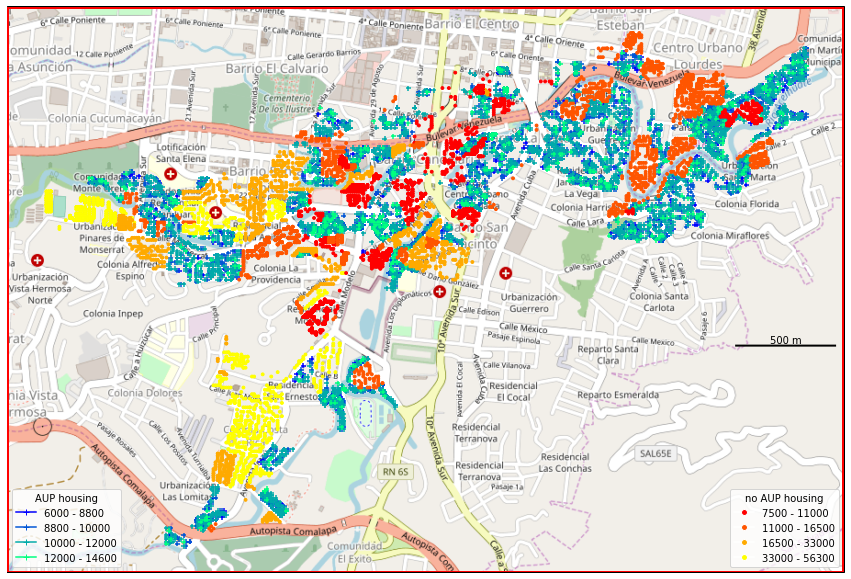

In [7]:
fig_houses

### SET UP THE EXPOSURE

The values and coordinates of these houses are gathered in the file `FL_entity_Acelhuate_houses.xlsx`. These can be loaded using climada's `Exposures`:   


In [8]:
import pandas as pd
from climada.entity import Exposures

ENT_FILE = 'FL_entity_Acelhuate_houses.xlsx' # entity file name

exp_acel = Exposures(pd.read_excel(ENT_FILE))
exp_acel.check() # check values are well set and assignes default values
exp_acel.head()  # show first 5 rows

,category,latitude,latitude.1,longitude,value,deductible,cover,if_FL,Value_unit
0,1,13.6905,13.6895,-89.1808,6105.62,0,0,101,USD
1,1,13.6879,13.6869,-89.1975,6309.79,0,0,101,USD
2,1,13.6820,13.6810,-89.1982,6535.10,0,0,101,USD
3,1,13.6941,13.6931,-89.1762,6563.85,0,0,101,USD
4,1,13.6809,13.6799,-89.1953,6586.88,0,0,101,USD


In this example, no house is insured; `deductible` and `cover` are set to 0. AUPs have the category id 1, whilst non AUP have the category 2.

In [9]:
# some statistics on AUPs and non AUPs
print('Number of houses, mean and total value of AUP and non AUP: \n')
print(exp_acel[['category', 'value']].groupby('category').agg(['count', 'mean', 'sum']))

Number of houses, mean and total value of AUP and non AUP: 

         value                            
         count          mean           sum
category                                  
1         6080  10314.287765  6.271087e+07
2         6392  18913.250939  1.208935e+08


`if_FL` variable refers to the id of the impact function related to each house. AUPs have impact function 101 and non AUPs the 102:

In [10]:
print(exp_acel[['category', 'if_FL']].groupby('category').agg(['unique']))

          if_FL
         unique
category       
1         [101]
2         [102]


The impact functions are defined in the sheet `impact_funcs` of `FL_entity_Acelhuate_houses.xlsx` and can be ingested using `ImpactFuncSet`:

MDD: mean damage ratio; PAA: percentage of afected assets; MDR = PAA*MDD: mean damage ratio:


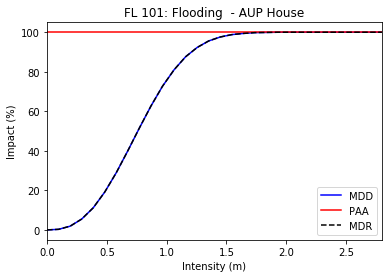

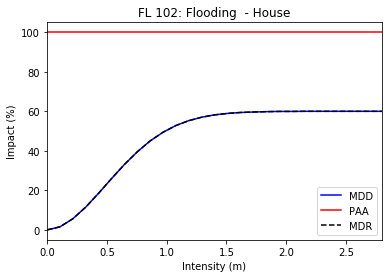

In [11]:
from climada.entity import ImpactFuncSet

if_acel = ImpactFuncSet()
if_acel.read_excel(ENT_FILE)
if_acel.check()

print('MDD: mean damage ratio; PAA: percentage of afected assets; MDR = PAA*MDD: mean damage ratio:')
if_acel.get_func('FL', 101).plot() # plot flood function 101
if_acel.get_func('FL', 102).plot() # plot flood function 102

### SET UP THE HAZARD

`Salvador_hazard_FL_2015B.mat` contains 6 different flood events in 10 m resolution with return periods [2, 5, 10, 25, 50, 100] in the studied region. Use climada's `Hazard` to handle them:

In [12]:
from climada.hazard import Hazard

HAZ_FILE = 'Salvador_hazard_FL_2015.mat'

haz_acel = Hazard('FL')     # set hazard type
haz_acel.read_mat(HAZ_FILE) # load file

/Users/aznarsig/Documents/Python/climada_python/climada/util/plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


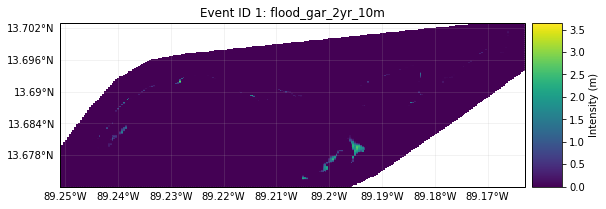

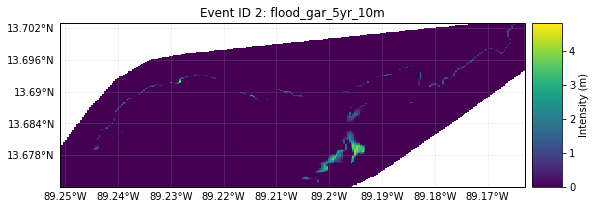

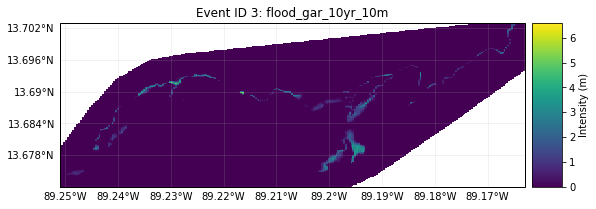

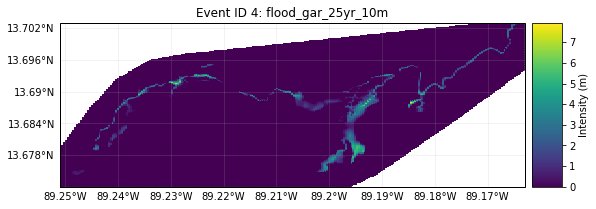

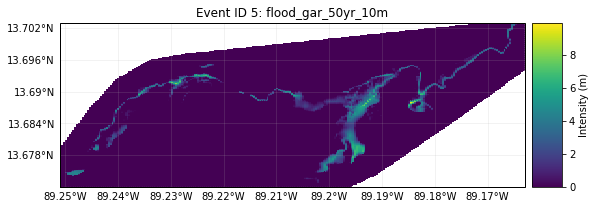

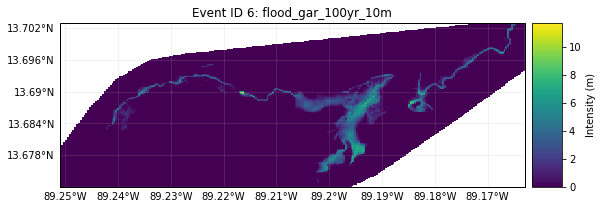

In [13]:
# plot every event
for ev_name in haz_acel.event_name:
    haz_acel.plot_intensity(ev_name)

### COMPUTING THE IMPACT

Risk metrics such as the annual expected impact or the exceedance probability curve can be easily obtained using climada's `Impact`:

In [14]:
from climada.engine import Impact

imp_acel = Impact()
imp_acel.calc(exp_acel, if_acel, haz_acel) # compute hazard's impact over exposure

Annual expected impact: 3.563e+06 USD


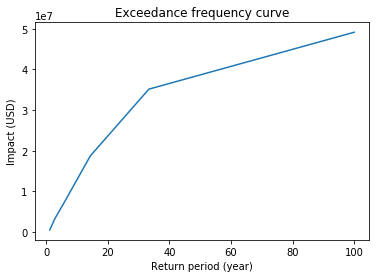

In [15]:
print('Annual expected impact: {:.3e} USD'.format(imp_acel.aai_agg)) # get average annual impact
imp_acel.calc_freq_curve().plot()                                    # plot exceedance frequency curve

The EAI computed in the previous section at 13.6856° N 89.193° W is reproduced:

In [16]:
point_idx = 1064
point_lat = exp_acel.latitude.values[point_idx]
point_lon = exp_acel.longitude.values[point_idx]
point_eai = imp_acel.eai_exp[point_idx]
print('Annual expected impact in {:.4f}° N {:.4f}° W is {:.0f} USD.'.format(-point_lat, point_lon, point_eai))

Annual expected impact in -13.6866° N -89.1939° W is 1125 USD.


Map the expected annual impact per house:

/Users/aznarsig/Documents/Python/climada_python/climada/util/plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


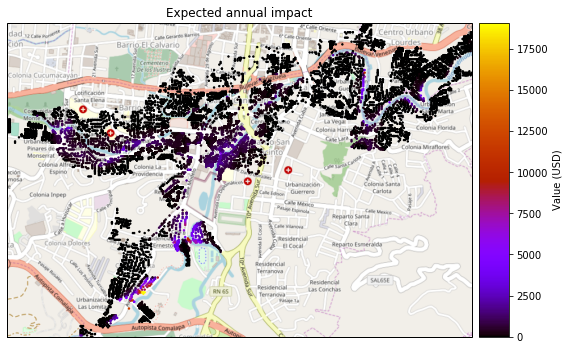

In [17]:
import contextily as ctx
imp_acel.plot_basemap_eai_exposure(url=ctx.sources.OSM_C, zoom=15, s=2, cmap='gnuplot')

Text(0.5, 1, 'Expected Annual Impact - no AUP')

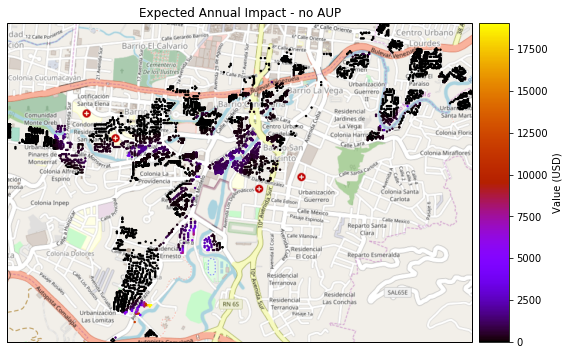

In [18]:
import numpy as np
ax = imp_acel.plot_basemap_eai_exposure(mask=np.argwhere(exp_acel.category==2).reshape(-1), url=ctx.sources.OSM_C, zoom=15, s=2, cmap='gnuplot')
ax.set_title('Expected Annual Impact - no AUP')

Text(0.5, 1, 'Expected Annual Impact - AUP')

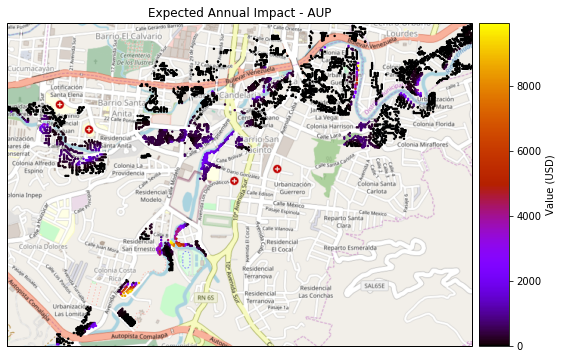

In [19]:
ax = imp_acel.plot_basemap_eai_exposure(mask=np.argwhere(exp_acel.category==1).reshape(-1), url=ctx.sources.OSM_C, zoom=15, s=2, cmap='gnuplot')
ax.set_title('Expected Annual Impact - AUP')

Further metrics can be extracted using the computed `Impact`'s attibutes:

In [20]:
eai_aup = imp_acel.eai_exp[exp_acel[exp_acel.category==1].index].sum()
print('Annual expected impact of AUPs: {:.3e} USD.'.format(eai_aup))
eai_per_aup = eai_aup/exp_acel[exp_acel.category==1].value.sum()*100
print('Annual expected impact of AUPs over its total value: {:.2f}%.'.format(eai_per_aup))

eai_no_aup = imp_acel.eai_exp[exp_acel[exp_acel.category==2].index].sum()
print('Annual expected impact of non AUPs: {:.3e} USD.'.format(eai_no_aup))
eai_per_no_aup = eai_no_aup/exp_acel[exp_acel.category==1].value.sum()*100
print('Annual expected impact of non AUPs over its total value: {:.2f}%.'.format(eai_per_no_aup))

Annual expected impact of AUPs: 1.817e+06 USD.
Annual expected impact of AUPs over its total value: 2.90%.
Annual expected impact of non AUPs: 1.746e+06 USD.
Annual expected impact of non AUPs over its total value: 2.78%.
